# Geospatial operations with Shapely: Round-Trip Reprojection, Affine Transformations, Rasterisation, and Vectorisation

Sometimes we want to take a geospatial object and transform it to a new coordinate system, and perhaps translate and rotate it by some amount. We may want to rasterise the object for raster operations. We'd like to do this all with Shapely geometry object so we have access to all their useful methods.

In [95]:
import json, geojson, pyproj
from shapely import geometry
from shapely.ops import transform
from shapely.affinity import affine_transform
from functools import partial
from skimage import measure
from scipy.ndimage.morphology import binary_dilation
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

## Reprojection-Affine-Rasterisation roundtrip

We're going to:
- take a shapely polygon with lon/lat coordinates, say the building footprint of the Oxford School of Geography and the Environment (SOGE)
- convert it to UTM coordinates
- draw it on a 1km raster with Oxford's Carfax tower landmarking the bottom left corner.

In [8]:
# grab a quick geojson from geojson.io
feature = json.loads("""{
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -1.2537717819213867,
              51.75935044524217
            ],
            [
              -1.2541741132736204,
              51.75922759060092
            ],
            [
              -1.2538844347000122,
              51.75860999193512
            ],
            [
              -1.2542277574539185,
              51.75844728980553
            ],
            [
              -1.2540507316589353,
              51.75822813907169
            ],
            [
              -1.2531226873397827,
              51.75858342836217
            ],
            [
              -1.2537717819213867,
              51.75935044524217
            ]
          ]
        ]
      }
    }""")

In [9]:
# load the polygon:
SOGE = geometry.shape(feature['geometry'])

### Forward and Reverse Projection
We want to convert the geometry from lon/lat to a cartesian coordinate system. Let's use Universal Transfer Mercator with units in m. The UTM projection is arranged in 'zones' to keep angles and shapes conformal in images.

In [17]:
# A function to grab the UTM zone number for any lat/lon location
def get_utm_zone(lat,lon):
    zone_str = str(int((lon + 180)/6) + 1)

    if ((lat>=56.) & (lat<64.) & (lon >=3.) & (lon <12.)):
        zone_str = '32'
    elif ((lat >= 72.) & (lat <84.)):
        if ((lon >=0.) & (lon<9.)):
            zone_str = '31'
        elif ((lon >=9.) & (lon<21.)):
            zone_str = '33'
        elif ((lon >=21.) & (lon<33.)):
            zone_str = '35'
        elif ((lon >=33.) & (lon<42.)):
            zone_str = '37'

    return zone_str

In [19]:
# get the UTM zone using the centroid of the polygon
utm_zone = get_utm_zone(SOGE.centroid.y, SOGE.centroid.x)

# define the native WGS84 lon/lat projection
proj_wgs = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# define the UTM projection using the utm zone
proj_utm = pyproj.Proj(proj='utm',zone=utm_zone,ellps='WGS84')

# create reprojection functions using functools.partial
reproj_wgs_utm = partial(pyproj.transform, proj_wgs, proj_utm)
reproj_utm_wgs = partial(pyproj.transform, proj_utm, proj_wgs)

In [38]:
# use shapely.transform with the reprojection functions to reproject shapely objects
SOGE_utm = transform(reproj_wgs_utm, SOGE)

In [76]:
# Check the reverse transform with a tolerance of 1e-9 of a decimal degree
print (SOGE.almost_equals(transform(reproj_utm_wgs, SOGE_utm), 1e-9))

True


### Affine Transformation
Now lets say we want to get a sense of the footprint of the School of Geograpy on a square kilometer of Oxford, with the bottom left corner centered on Carfax tower. We want to create a mask of the building footprint on a numpy array.

<div>
<img src="https://user-images.githubusercontent.com/22874837/74949464-b52dec00-53f5-11ea-9107-53d91c93d70c.png" width="500"/>
</div>

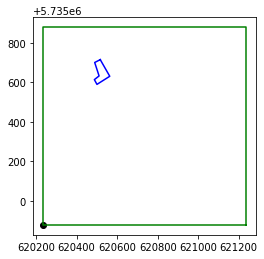

In [59]:
# Point for Carfax tower
carfax = geometry.Point(-1.25812, 51.7519)

# Convert the point to utm
carfax_utm = transform(reproj_wgs_utm,carfax)

# use the utm point as the lower-left coordinate for a shapely box
oxford_box = geometry.box(carfax_utm.x, carfax_utm.y, carfax_utm.x+1000, carfax_utm.y+1000)

# visualise
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(*SOGE_utm.exterior.xy,c='b')
ax.scatter(carfax_utm.x, carfax_utm.y, c='k')
ax.plot(*oxford_box.exterior.xy,c='g')
plt.show()

We'll choose the pixel resolution of our numpy array to be 25m. We'll use a [shapely affine tranformation](https://shapely.readthedocs.io/en/latest/manual.html#affine-transformations) with a geotransform to transform the shape to pixel coordinates. *Note!* The Shapely Geotransform matrix is different than many other spatial packages (e.g. GDAL, PostGIS).

In [72]:
# Define the geotransform matrix
a = e = 1/25 # stretch along-axis 25m/px

b = d = 0 # rotate across-axis 0m/px

x_off = - carfax_utm.x / 25 # offset from cartesian origin in pixel coordinates

y_off = - carfax_utm.y / 25 # offset from cartesian origin in pixel coordinates

GT = [a,b,d,e,x_off,y_off] # GeoTransform Matrix

In [75]:
# Apply GeoTransform
SOGE_pix = affine_transform(SOGE_utm,GT)

### Rasterising
Lastly, let's say we want to rasterise our converted polygons to create a numpy array mask. Let's use PIL to draw our polygon on a numpy array.

In [146]:
# initialise a numpy array
SOGE_mask = np.zeros((int(1000/25), int(1000/25))) # 1000m / 25m/px

# create an Image object
im = Image.fromarray(mask, mode='L')

# create an ImageDraw object
draw = ImageDraw.Draw(im)

# draw the polygon
draw.polygon(list(SOGE_pix.exterior.coords), fill=255)

# un-draw any holes in the polygon...
for hole in SOGE_pix.interiors:
    draw.polygon(list(hole.coords), fill=0)
    
# return the image object to the mask array
SOGE_mask = np.array(im)

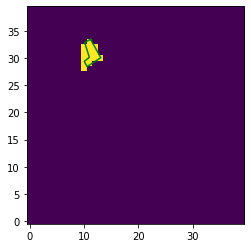

In [147]:
# visualise
fix, ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(SOGE_mask, origin='lower')
ax.plot(*SOGE_pix.exterior.xy, c='g')
plt.show()

### Vectorising
To complete the round-trip, lets perform a raster operation (say, a [simple binary dialation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_dilation.html)), then re-vectorise our polygon and get it all the way back to native lat-lon coordinates. We'll use a vectoriser built with [skimage.measure.find_contours](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours).

In [165]:
def vectoriser(arr, disp=2):
    """
    input: arr -> a square 2D binary mask array
    output: polys -> a list of vectorised polygons
    """    
    
    polys = []

    contours = measure.find_contours(np.pad(arr,disp,'constant', constant_values=(0)), 0.0001)
    
    for c in contours:
        c = (c-disp).clip(0.,float(arr.shape[0])) # clip back extraneous geomtries
        c = np.round(c) # round to int
        c.T[[0, 1]] = c.T[[1, 0]] # swap lons<->lats
        poly = geometry.Polygon(c) # pass into geometry
        polys.append(poly)
    return polys

In [166]:
# grab the 0th element in the list of polygons
SOGE_dialated = vectoriser(binary_dilation(SOGE_mask>0))[0]

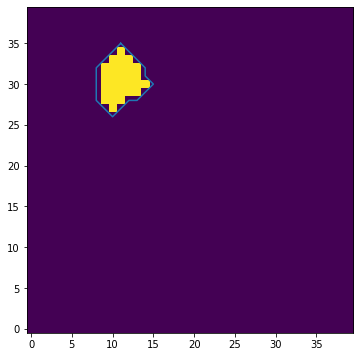

In [167]:
# Visualise
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(binary_dilation(SOGE_mask),origin='lower')
ax.plot(*SOGE_dialated.exterior.xy)
plt.show()

Now we need to convert this polygon in the pixel coordinate system back to the UTM coordinate system, and finally back to lon/lat. We do this by first reversing the affine transformation, and then reversing the projection.

In [168]:
GT_rev = [1/a,b,d,1/e,carfax_utm.x, carfax_utm.y]

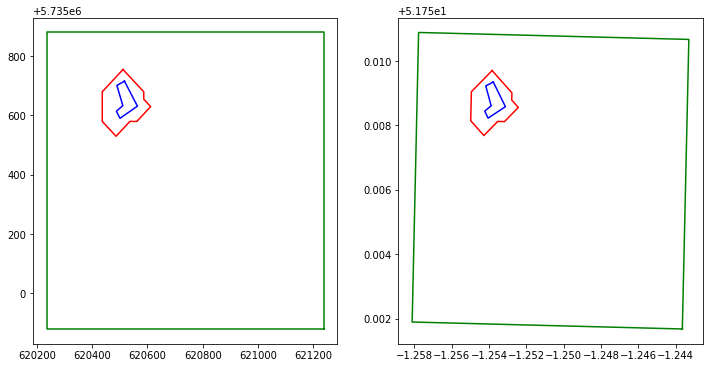

In [169]:
# visualise
fig, axs = plt.subplots(1,2,figsize=(12,6))
#utm polygons
axs[0].plot(*affine_transform(SOGE_dialated, GT_rev).exterior.xy,c='r')
axs[0].plot(*SOGE_utm.exterior.xy, c='b')
axs[0].plot(*oxford_box.exterior.xy,c='g')
#lon/lat polygons
axs[1].plot(*transform(reproj_utm_wgs,affine_transform(SOGE_dialated, GT_rev)).exterior.xy,c='r')
axs[1].plot(*transform(reproj_utm_wgs,SOGE_utm).exterior.xy, c='b')
axs[1].plot(*transform(reproj_utm_wgs,oxford_box).exterior.xy,c='g')
plt.show()